# Aprenentatge Automàtic per a Xarxes (ML4Net)
## Seminar 5

### 1 - Part I: ML model definition

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the ML model
def create_model():
    model = models.Sequential([
        layers.Input(shape=(270,)),  # Input shape for flattened CSI matrix (30x3x3)
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.2),
        layers.Dense(5, activation='softmax')  # 5 classes: wave, push, crouch, sitdown, bend
    ])
    model.compile(optimizer='adam',
                 loss='sparse_categorical_crossentropy',
                 metrics=['accuracy'])
    return model

### 2 - Part II: Preparation of the FL setting

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Client 1 labels (before adjustment): min=1, max=11
Client 1 labels (after modulo remapping): min=1, max=5
Client 1 labels (after final adjustment): min=0, max=4
Client 2 labels (before adjustment): min=2, max=7
Client 2 labels (after modulo remapping): min=2, max=2
Client 2 labels (after final adjustment): min=1, max=1
Client 3 labels (before adjustment): min=2, max=11
Client 3 labels (after modulo remapping): min=1, max=5
Client 3 labels (after final adjustment): min=0, max=4
Client 4 labels (before adjustment): min=1, max=9
Client 4 labels (after modulo remapping): min=1, max=4
Client 4 labels (after final adjustment): min=0, max=3
Client 5 labels (before adjustment): min=3, max=8
Client 5 labels (after modulo remapping): min=1, max=3
Client 5 labels (after final adjustment): min=0, max=2
Client 6 labels (before adjustment): min=5, max=12
Client 6 labels (a

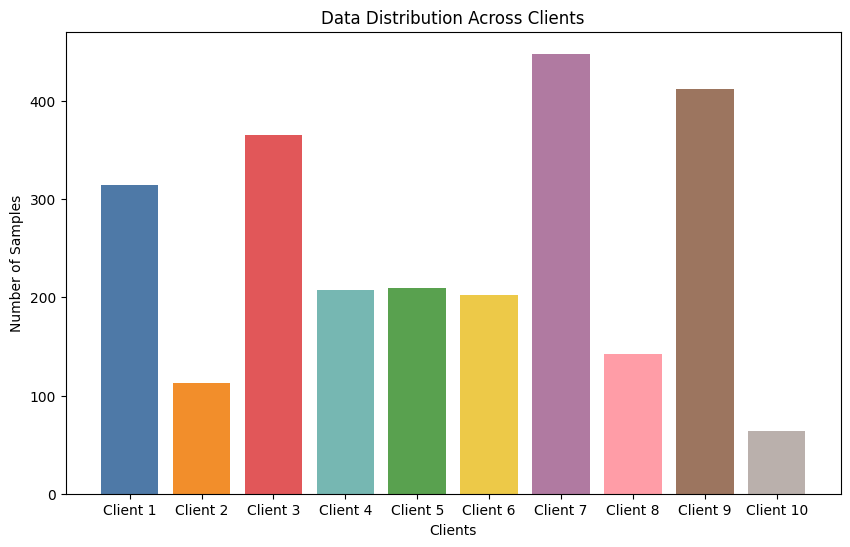

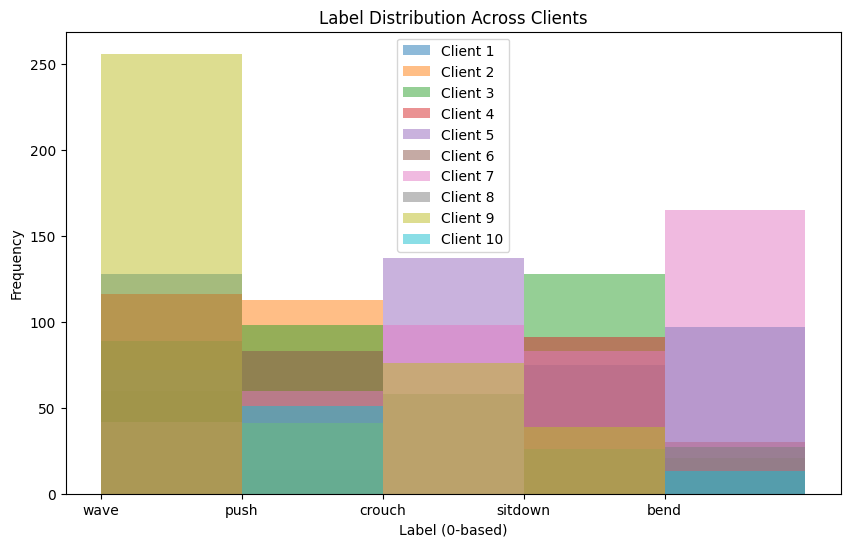

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import random
from google.colab import drive
import os
import matplotlib.pyplot as plt

drive.mount('/content/drive')

BASE_PATH = '/content/drive/MyDrive/3r/ML4N/MLforNetworks/dataset_Seminar5/'
CLIENT_DATA_PATH = os.path.join(BASE_PATH, 'client_datasets/')
NUM_CLIENTS = 10

# Load and preprocess client data
def load_client_data(client_id):
    features = pd.read_csv(f'{CLIENT_DATA_PATH}client_{client_id}_features.csv', header=None).values
    labels = pd.read_csv(f'{CLIENT_DATA_PATH}client_{client_id}_labels.csv', header=None).values.flatten()

    # Debugging: Check the range of labels before adjustment
    print(f"Client {client_id} labels (before adjustment): min={np.min(labels)}, max={np.max(labels)}")

    # Check for invalid labels and remap using modulo to [1, 5]
    invalid_mask = (labels < 1) | (labels > 5)
    if np.any(invalid_mask):
        invalid_labels = labels[invalid_mask]
        print(f"Warning: Client {client_id} contains {len(invalid_labels)} invalid labels (e.g., {invalid_labels[:5]}). Remapping with modulo.")
        labels = (labels - 1) % 5 + 1

    print(f"Client {client_id} labels (after modulo remapping): min={np.min(labels)}, max={np.max(labels)}")

    # Validate labels: Ensure they are within the range [1, 5]
    if np.min(labels) < 1 or np.max(labels) > 5:
        invalid_labels = labels[(labels < 1) | (labels > 5)]
        raise ValueError(f"Client {client_id} contains invalid labels after remapping: {invalid_labels}. Expected range is [1, 5].")

    labels = labels - 1

    # Debugging: Check the range of labels after final adjustment
    print(f"Client {client_id} labels (after final adjustment): min={np.min(labels)}, max={np.max(labels)}")

    return features, labels

def load_test_data():
    features = pd.read_csv(f'{BASE_PATH}test_features.csv', header=None).values
    labels = pd.read_csv(f'{BASE_PATH}test_labels.csv', header=None).values.flatten()

    # Debugging: Check the range of labels before adjustment
    print(f"Test labels (before adjustment): min={np.min(labels)}, max={np.max(labels)}")

    # Check for invalid labels and remap using modulo to [1, 5]
    invalid_mask = (labels < 1) | (labels > 5)
    if np.any(invalid_mask):
        invalid_labels = labels[invalid_mask]
        print(f"Warning: Test dataset contains {len(invalid_labels)} invalid labels (e.g., {invalid_labels[:5]}). Remapping with modulo.")
        labels = (labels - 1) % 5 + 1

    # Debugging: Check the range of labels after modulo remapping
    print(f"Test labels (after modulo remapping): min={np.min(labels)}, max={np.max(labels)}")

    # Validate labels: Ensure they are within the range [1, 5]
    if np.min(labels) < 1 or np.max(labels) > 5:
        invalid_labels = labels[(labels < 1) | (labels > 5)]
        raise ValueError(f"Test dataset contains invalid labels after remapping: {invalid_labels}. Expected range is [1, 5].")

    labels = labels - 1

    # Debugging: Check the range of labels after final adjustment
    print(f"Test labels (after final adjustment): min={np.min(labels)}, max={np.max(labels)}")

    return features, labels

# Create datasets for all clients and collect data sizes
client_datasets = []
data_sizes = []
all_labels = []
for i in range(1, NUM_CLIENTS + 1):
    X, y = load_client_data(i)
    dataset = tf.data.Dataset.from_tensor_slices((X, y)).shuffle(buffer_size=1000).batch(32)
    client_datasets.append((X, y, dataset))
    data_sizes.append(len(X))
    all_labels.append(y)

X_test, y_test = load_test_data()
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32)

def fed_avg_aggregation(client_models, client_data_sizes):
    total_samples = sum(client_data_sizes)
    weights = client_models[0].get_weights()
    aggregated_weights = [np.zeros_like(w) for w in weights]

    for client_model, size in zip(client_models, client_data_sizes):
        client_weights = client_model.get_weights()
        weight_factor = size / total_samples
        for i in range(len(aggregated_weights)):
            aggregated_weights[i] += client_weights[i] * weight_factor

    return aggregated_weights

print("Number of samples per client:", data_sizes)

# Create a bar plot for data distribution
plt.figure(figsize=(10, 6))
plt.bar(range(1, NUM_CLIENTS + 1), data_sizes, color=['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
                                                      '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac'])
plt.xlabel('Clients')
plt.ylabel('Number of Samples')
plt.title('Data Distribution Across Clients')
plt.xticks(range(1, NUM_CLIENTS + 1), [f'Client {i}' for i in range(1, NUM_CLIENTS + 1)])
plt.show()

# Create a histogram for label distribution across all clients
plt.figure(figsize=(10, 6))
for i in range(NUM_CLIENTS):
    plt.hist(all_labels[i], bins=range(6), alpha=0.5, label=f'Client {i+1}')
plt.xlabel('Label (0-based)')
plt.ylabel('Frequency')
plt.title('Label Distribution Across Clients')
plt.legend()
plt.xticks(range(5), ['wave', 'push', 'crouch', 'sitdown', 'bend'])
plt.show()

###  3 - Part III: Collaborative training of the model

In [ ]:

global_model = create_model()

NUM_ROUNDS = 50
CLIENTS_PER_ROUND = 5
LOCAL_EPOCHS = 5

for round_num in range(NUM_ROUNDS):
    print(f'Round {round_num + 1}/{NUM_ROUNDS}')

    selected_clients = random.sample(range(NUM_CLIENTS), CLIENTS_PER_ROUND)     #Select random clients

    client_models = []
    client_data_sizes = []

    #Train on selected clients
    for client_id in selected_clients:
        client_model = create_model()
        client_model.set_weights(global_model.get_weights())
        X_client, y_client, client_dataset = client_datasets[client_id]
        client_model.fit(client_dataset, epochs=LOCAL_EPOCHS, verbose=0)
        client_models.append(client_model)
        client_data_sizes.append(len(X_client))

    # Aggregate models
    new_weights = fed_avg_aggregation(client_models, client_data_sizes)
    global_model.set_weights(new_weights)

    # Evaluate global model
    test_loss, test_accuracy = global_model.evaluate(test_dataset, verbose=0)
    print(f'Test accuracy after round {round_num + 1}: {test_accuracy:.4f}')

# Final evaluation
test_loss, test_accuracy = global_model.evaluate(test_dataset, verbose=0)
print(f'\nFinal Test Accuracy: {test_accuracy:.4f}')

# Save the model (updated path)
global_model.save('/content/drive/MyDrive/3r/ML4N/MLforNetworks/dataset_Seminar5/global_model.h5')

Round 1/50
Test accuracy after round 1: 0.2400
Round 2/50
Test accuracy after round 2: 0.2980
Round 3/50
Test accuracy after round 3: 0.3160
Round 4/50
Test accuracy after round 4: 0.2420
Round 5/50
Test accuracy after round 5: 0.2360
Round 6/50
Test accuracy after round 6: 0.2500
Round 7/50
Test accuracy after round 7: 0.2660
Round 8/50
Test accuracy after round 8: 0.2440
Round 9/50
Test accuracy after round 9: 0.2420
Round 10/50
Test accuracy after round 10: 0.2700
Round 11/50
Test accuracy after round 11: 0.3180
Round 12/50
Test accuracy after round 12: 0.3220
Round 13/50
Test accuracy after round 13: 0.2480
Round 14/50
Test accuracy after round 14: 0.2440
Round 15/50
Test accuracy after round 15: 0.2420
Round 16/50
Test accuracy after round 16: 0.3240
Round 17/50
Test accuracy after round 17: 0.3120
Round 18/50
Test accuracy after round 18: 0.3160
Round 19/50
Test accuracy after round 19: 0.3240
Round 20/50
Test accuracy after round 20: 0.3000
Round 21/50
Test accuracy after round 

Test accuracy after round 50: 0.3220

Final Test Accuracy: 0.3220
